# Modflow Debug GUI

Load formatting extension

In [1]:
%load_ext lab_black

Set matplotlib backend

In [2]:
%matplotlib inline

In [3]:
import os
import sys

from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import flopy
import flopy.utils.binaryfile as bf

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

flopy is installed in C:\Users\hofer_jn\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy
3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.16.5
matplotlib version: 3.1.1
flopy version: 3.2.12


In [4]:
sim_name = "mfsim.nam"
modflow_path = Path("c:/checkouts/modflow6/bin/mf6d.exe")
sim_path = Path("c:/checkouts/modflow-debug-gui/data/test120_mv_dis-lgr_3models")

sim = flopy.mf6.MFSimulation.load(
    sim_name=sim_name, version="mf6", exe_name=str(modflow_path), sim_ws=str(sim_path),
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package rch...
    loading package riv...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package riv...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 15 based on size of stress_period_data
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package riv...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 15 based on size of stress_period_data
    loading package oc...
  loading exchange package gwf-gwf_exg_0...
  loading exchange package gwf-gwf_exg_1...
  loading exchange package gwf-gwf_exg_2.

Manual way to run modflow executable
```python
import subprocess
import os
os.chdir(example_path)
completed_process = subprocess.run([str(modflow_path)], stdout=subprocess.PIPE)
if completed_process.returncode:
    print(completed_process.stdout.decode("utf-8"))
```

Multiple models can be attached to a mf6 simulation. 

Model names can be obtained by using the .model_names attribute of the MFSimulation object

In [5]:
list(sim.model_names)

['mv', 'child1', 'child2']

Run modflow with flopy

In [6]:
sim.run_simulation()

FloPy is using the following  executable to run the model: c:\checkouts\modflow6\bin\mf6d.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.5 03/31/2019
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Nov 06 2019 14:55:12 with IFORT compiler (ver. 19.0.4)

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use of the softwar

(True, [])

## Plotting simulated model results

First we create an instance of the HeadFile class with the simulated head file (*.hds) and extract the simulation times available in the binary head file using the `.get_times()` method. Here we plot last simulated heads in the binary heads file (`totim=times[-1]`). We are also masking cells having the HDRY (1e+30) value and adding a colorbar.

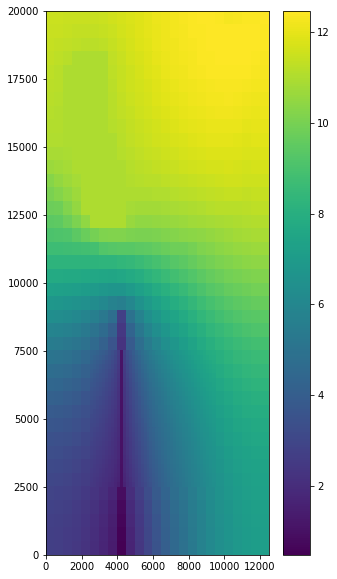

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 10)
layer = 0


models = []
headobjects = []
times = None
plotarrays = []
xgrids = []
ygrids = []
vmin = np.inf
vmax = -np.inf

for i, model_name in enumerate(list(sim.model_names)):
    models.append(sim.get_model(model_name))

    hds_name = sim_path / (model_name + ".hds")
    headobjects.append(flopy.utils.HeadFile(hds_name, model=models[i]))

    times = headobjects[i].get_times()

    # Get heads of layer at end of simulation (times[-1])
    plotarray = headobjects[i].get_data(totim=times[-1])[layer, :, :]

    # Mask cells having the HDRY (1e+30) value
    plotarrays.append(np.ma.masked_equal(plotarray, [1e30]))

    xgrids.append(np.array(models[i].modelgrid.xvertices))
    ygrids.append(np.array(models[i].modelgrid.yvertices))

    local_min = np.min(plotarrays[i])
    if local_min < vmin:
        vmin = local_min

    local_max = np.max(plotarrays[i])
    if local_max > vmax:
        vmax = local_max


for i in range(0, len(plotarrays)):
    cm = ax.pcolormesh(xgrids[i], ygrids[i], plotarrays[i], vmin=vmin, vmax=vmax)


fig.colorbar(cm, ax=ax)

New way to extract head-data with Flopy

In [9]:
# [-1] in order to get date from the (time) end of the model run
head_mv = sim.simulation_data.mfdata["mv", "HDS", "HEAD"][-1]
head_child1 = sim.simulation_data.mfdata["child1", "HDS", "HEAD"][-1]
head_child2 = sim.simulation_data.mfdata["child2", "HDS", "HEAD"][-1]

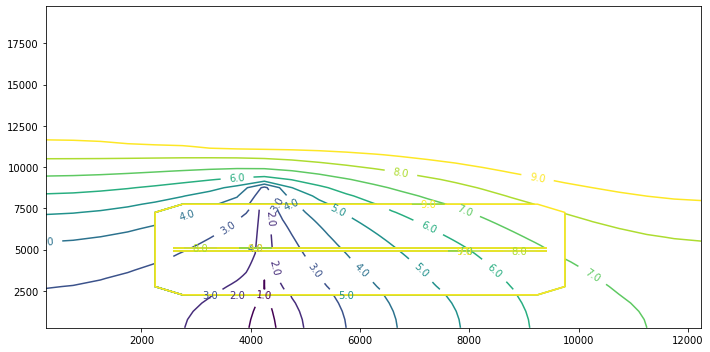

In [10]:
plt.figure(figsize=(10, 5))
levels = np.arange(1, 10, 1)


xorigin = 0
yorigin = 0
nlay = 5
nrow = 40
ncol = 25
delr = 500
delc = 500
Lx = delr * ncol
Ly = delc * nrow
extent = (delr / 2.0, Lx - delr / 2.0, Ly - delc / 2.0, delc / 2.0)
c = plt.contour(head_mv[0, :, :], levels=levels, extent=extent)
plt.clabel(c, fmt="%1.1f")

xorigin = 2500
yorigin = 2500
nlay = 5
nrow = 30
ncol = 42
delr = 166.66666667
delc = 166.66666667
Lx = delr * ncol
Ly = delc * nrow
extent = (
    delr / 2.0 + xorigin,
    Lx - delr / 2.0 + xorigin,
    Ly - delc / 2.0 + yorigin,
    delc / 2.0 + yorigin,
)
c = plt.contour(head_child1[0, :, :], levels=levels, extent=extent)
plt.clabel(c, fmt="%1.1f")

xorigin = 2500
yorigin = 2500
nlay = 5
nrow = 30
ncol = 42
delr = 166.66666667
delc = 166.66666667
Lx = delr * ncol
Ly = delc * nrow
extent = (
    delr / 2.0 + xorigin,
    Lx - delr / 2.0 + xorigin,
    Ly - delc / 2.0 + yorigin,
    delc / 2.0 + yorigin,
)
c = plt.contour(head_child2[0, :, :], levels=levels, extent=extent)
plt.clabel(c, fmt="%1.1f")

plt.tight_layout()
plt.show()

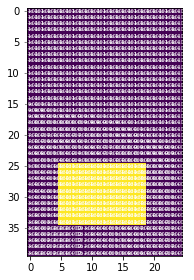

In [12]:
# plt.figure(figsize=(20, 5))

# plt.subplot(1, 3, 1, aspect="equal")
hds = bf.HeadFile(sim_path / "mv.hds")
head = hds.get_data(totim=1.0)
levels = np.arange(1, 10, 1)
plt.imshow(head[0, :, :])

for i in range(len(head[0, 0, :])):
    for j in range(len(head[0, :, 0])):
        text = plt.text(
            i,
            j,
            f"{head[0, j, i]:02.0}",
            ha="center",
            va="center",
            color="w",
            fontsize=5,
        )


# plt.subplot(1, 3, 2)
# hds = bf.HeadFile("child1.hds")
# head = hds.get_data(totim=1.0)
# levels = np.arange(1, 10, 1)
# plt.imshow(head[0, :, :])

# plt.subplot(1, 3, 3)
# hds = bf.HeadFile("child2.hds")
# head = hds.get_data(totim=1.0)
# levels = np.arange(1, 10, 1)
# plt.imshow(head[0, :, :])
# plt.colorbar()

plt.tight_layout()
plt.show()